In [1]:
##importação de bibliotecas e definições gerais

import matplotlib.pyplot as plt

import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

%matplotlib inline
plt.style.use('ggplot')

pd.options.display.float_format = '{:.2f}'.format

In [139]:
tipos = {
    'bugged_date': 'category',
    'deputy_id': np.int64,
    'political_party': 'category',
    'state_code': 'category',
    'deputy_name': object,
    'receipt_social_security_number': object,
    'receipt_description': object,
    'establishment_name': object,
    'receipt_value': np.float64
}
reembolsos = pd.read_csv('./deputies_reimbursements/deputies_dataset.csv', dtype=tipos, parse_dates=['receipt_date'])
reembolsos['receipt_year'] = pd.DatetimeIndex(reembolsos['receipt_date']).year
reembolsos['receipt_month'] = pd.DatetimeIndex(reembolsos['receipt_date']).month
reembolsos['receipt_day_of_month'] = pd.DatetimeIndex(reembolsos['receipt_date']).day
reembolsos['qtd_reembolsos'] = 1

In [140]:
reembolsos.dtypes

bugged_date                             category
receipt_date                      datetime64[ns]
deputy_id                                  int64
political_party                         category
state_code                              category
deputy_name                               object
receipt_social_security_number            object
receipt_description                       object
establishment_name                        object
receipt_value                            float64
receipt_year                               int64
receipt_month                              int64
receipt_day_of_month                       int64
qtd_reembolsos                             int64
dtype: object

In [141]:
reembolsos.describe()

,deputy_id,receipt_value,receipt_year,receipt_month,receipt_day_of_month,qtd_reembolsos
count,3014902.00,3014902.00,3014902.00,3014902.00,3014902.00,3014902.00
mean,1869.10,579.16,2012.99,6.48,14.87,1.00
std,701.48,1925.42,2.46,3.30,9.00,0.00
min,12.00,0.00,2009.00,1.00,1.00,1.00
25%,1467.00,50.00,2011.00,4.00,7.00,1.00
50%,1882.00,142.00,2013.00,6.00,15.00,1.00
75%,2340.00,472.00,2015.00,9.00,23.00,1.00
max,3173.00,215000.00,2017.00,12.00,31.00,1.00


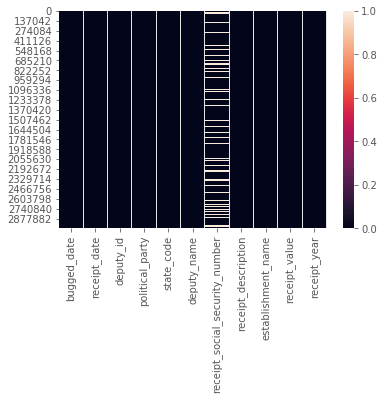

In [6]:
sns.heatmap(reembolsos.isnull())

In [6]:
# Não estou interessado em recibos em que eu não consiga identificar o CNPJ/CPF do estabelecimento, apesar disso, eventualmente 
# poderíamos avaliar o que consta aqui.
reembolsos.loc[reembolsos['receipt_social_security_number'].isnull()].describe()

,deputy_id,receipt_value,receipt_year,receipt_month,receipt_day_of_month
count,520952.00,520952.00,520952.00,520952.00,520952.00
mean,1743.67,206.05,2012.42,6.33,14.09
std,694.87,723.95,2.35,3.56,9.28
min,12.00,0.00,2009.00,1.00,1.00
25%,1311.00,25.00,2010.00,3.00,6.00
50%,1825.00,57.00,2012.00,6.00,14.00
75%,2276.00,193.00,2014.00,9.00,22.00
max,3173.00,149754.00,2017.00,12.00,31.00


C:\Users\Marco\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Marco\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


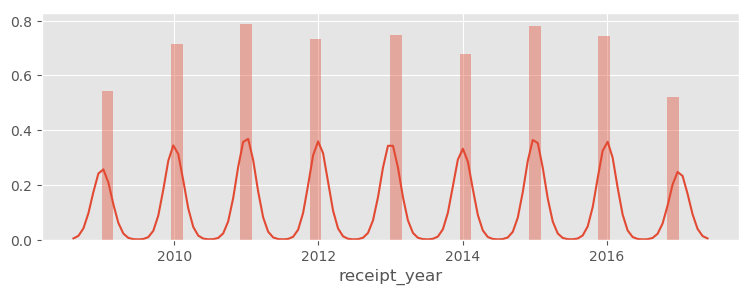

In [5]:
fig = plt.figure(figsize=(9,3), dpi=100)
sns.distplot(reembolsos['receipt_year'])


In [149]:
# Removendo recibos sem cpf/cnpj do fornecedor
# Também não tenho interesse em avaliar recibos com valor igual a 0.
reembolsos = reembolsos.loc[ (~ reembolsos['receipt_social_security_number'].isnull())]
reembolsos = reembolsos.loc[ (reembolsos['receipt_social_security_number'] != '0.0')]
reembolsos = reembolsos.loc[ (reembolsos['receipt_value']!=0)]
reembolsos.describe()

,deputy_id,receipt_value,receipt_year,receipt_month,receipt_day_of_month,qtd_reembolsos
count,2492429.00,2492429.00,2492429.00,2492429.00,2492429.00,2492429.00
mean,1895.30,657.49,2013.11,6.52,15.03,1.00
std,699.98,2083.12,2.47,3.24,8.93,0.00
min,12.00,1.00,2009.00,1.00,1.00,1.00
25%,1531.00,63.00,2011.00,4.00,7.00,1.00
50%,1896.00,160.00,2013.00,6.00,15.00,1.00
75%,2349.00,543.00,2015.00,9.00,23.00,1.00
max,3173.00,215000.00,2017.00,12.00,31.00,1.00


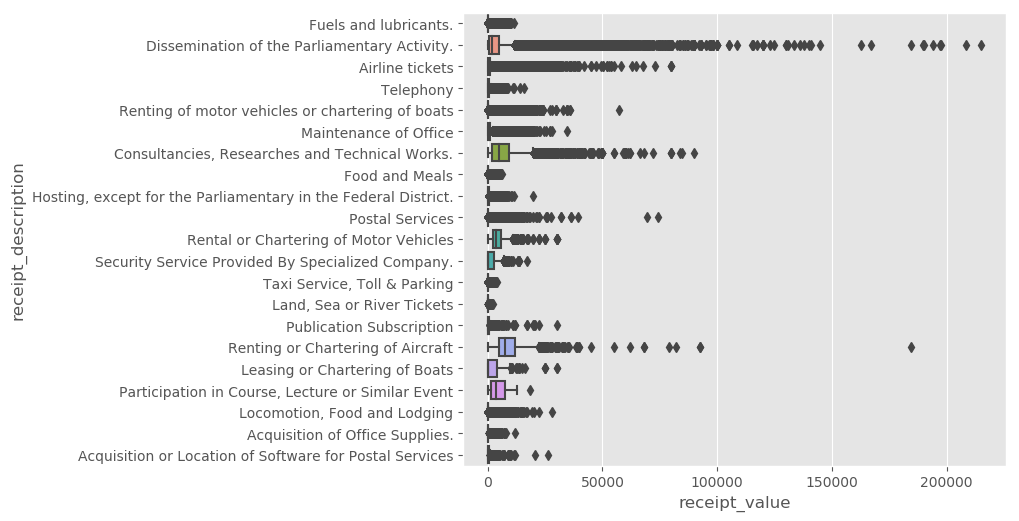

In [8]:
# Avaliação sobre a distribuição de valores em função do tipo de gasto
fig = plt.figure(figsize=(7,6), dpi=100)
sns.boxplot(data=reembolsos, y='receipt_description', x='receipt_value')

In [7]:
reembolsos.shape

(2492434, 13)

In [183]:
# Avaliação e ajuste de cpf/cnpj de fornecedor em vários tipos de gasto e nome de fornecedor
r = reembolsos.groupby(['receipt_social_security_number', 'receipt_description']).sum().iloc[:,[5]]
r.reset_index('receipt_description', inplace=True)
r

,receipt_description,qtd_reembolsos
receipt_social_security_number,,
1000937000120.0,Food and Meals,1
1000937000120.0,"Hosting, except for the Parliamentary in the F...",7
1001182000188.0,Fuels and lubricants.,3
10012052000484.0,Fuels and lubricants.,2
1001211000101.0,Dissemination of the Parliamentary Activity.,7
10013396000165.0,Food and Meals,6
10013417000142.0,Fuels and lubricants.,1
10013441000262.0,Food and Meals,1
10013441000262.0,"Hosting, except for the Parliamentary in the F...",7


In [152]:
reembolsos.groupby(['receipt_social_security_number', 'establishment_name']).sum().iloc[:,[5]]

qtd_reembolsos
receipt_social_security_number establishment_name                                               
1000937000120.0                HOTEL BERGOZZA LTDA                                             8
1001182000188.0                J N FREITAS SILVA COMBUISTIVEIS                                 1
                               J N FREITAS SILVA COMBUSTIVEIS                                  2
10012052000484.0               IMPORTADORA BEZERRA FILHOS LTDA                                 2
1001211000101.0                MANOEL GONZAGA SILVA                                            7
10013396000165.0               MJ COMERCIO DE ALIMENTOS LTDA                                   1
                               MJ COMÉRCIO DE ALIMENTOS                                        5
10013417000142.0               Posto Aliança Nunes                                             1
10013441000262.0               ZEIN ORTECE INCORPORAÇÕES LTDA                                  8
10013600000148.0               MENEZES CARVALHO & MARINHO LTDA.                                5
10014076000120.0               MARAVILHA TAXI AÉREO                                            2
10014394000190.0               PULSO COMUNICAÇÕES LTDA ME                                      6
10014549000199.0               BRK - SEGURANÇA INTEGRADA LTDA                                 18
                               BRK - SEGURANÇA INTEGRADA LTDA.                                 5
                               BRK - SEGURANÇA INTEGRAL LTDA                                   1
                               BRK SEGURANÇA INTEGRADA LTDA                                    6
                               BRK- SEGURANÇA INTEGRADA LTDA                                   2
                               BRK-SEGURANÇA INTEGRADA LTDA                                    2
10014575000117.0               CHOPERIA COLORADO LTDA ME                                       3
10015418000126.0               FOLHA DO NORTE                                                  2
10015535000270.0               GASPEL LTDA                                                     2
10015535000947.0               GAPEL LTDA                                                      6
10015535001080.0               gapel ltda                                                      2
10015535001404.0               GAPEL LTDA                                                     37
                               GAPEL LTDA.                                                     1
10015563000107.0               RAFAEL FILIPE FACHINI ME                                        1
10015779000172.0               POSTO ARIEL LTDA                                                1
10015901000100.0               Rodosnack Estrela da dutra                                      2
10016430000155.0               RESTAURANTE GISELE                                              1
1001687000142.0                Imperial Indústria Gráfica                                      7
...                                                                                          ...
9967852018417.0                HOTELARIA ACCOR BRASIL S/A                                      1
9967852018506.0                Mercure Ribeirão Preto                                          3
9967852019065.0                IBIS                                                            1
9967852019499.0                HOTELARIA ACCOR BRASIL SA                                       1
997222000120.0                 POSTO TREVO DE BUZIOS                                           8
99723425815.0                  JOVANE DE MELO PAZ                                             19
997808000195.0                 A THOMASI E CIA LTDA                                            1
                               THOMAS HOTEL                                                    1
                               THOMASI HOTEL                                                   7
        

In [7]:
# Vou concentrar a análise abandonando os outliers.

def get_outlier_media(s, sd_q_out=3.0):
    """
    Return boolean qualifier for outliers from a pandas series
    using standard deviation.
    param sd_q_out:
        Standard deviation multiplier factor to qualify as outlier.
    :type sd_q_out: ``float``
    """
    data_mean, data_std = s.mean(), s.std()
    cut_off = data_std * sd_q_out
    lower, upper = data_mean - cut_off, data_mean + cut_off
    
    return [True if x < lower or x > upper else False for x in s]

def get_outlier_interquartil(s, k=1.5):
    """
    Return a boolean qualifier for outliers from a pandas series
    using interquartile range.
    param k:
        Multiplier factor to qualify as outlier
    :type k: ``float``
    """
    q25, q75 = np.percentile(s, 25), np.percentile(s, 75)
    iqr = q75 - q25
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    
    return [True if x < lower or x > upper else False for x in s]

In [8]:
reembolsos['oulier_interquartil'] = get_outlier_interquartil(reembolsos['receipt_value'])
reembolsos['oulier_std_deviation'] = get_outlier_media(reembolsos['receipt_value'])

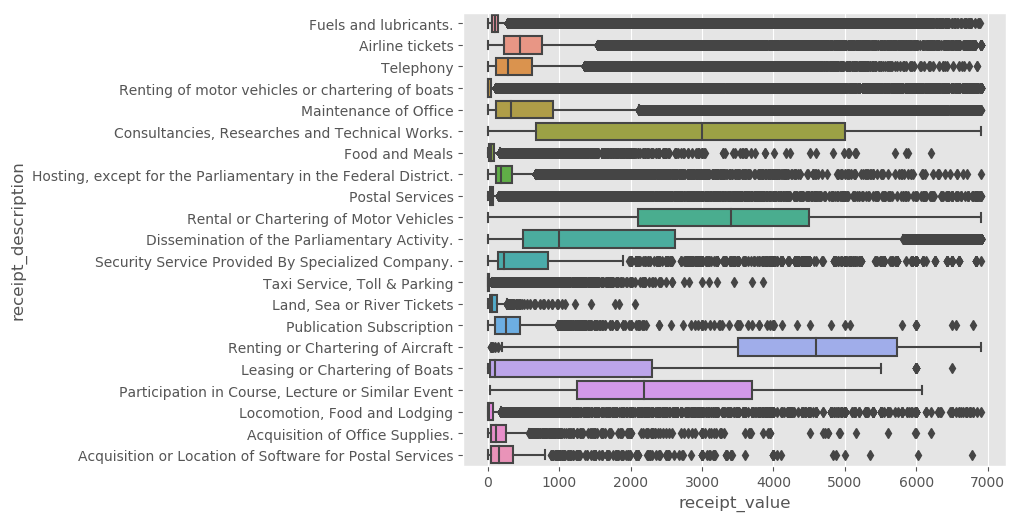

In [9]:
fig = plt.figure(figsize=(7,6), dpi=100)
sns.boxplot(data=reembolsos[~reembolsos['oulier_std_deviation']], x='receipt_value', y='receipt_description')

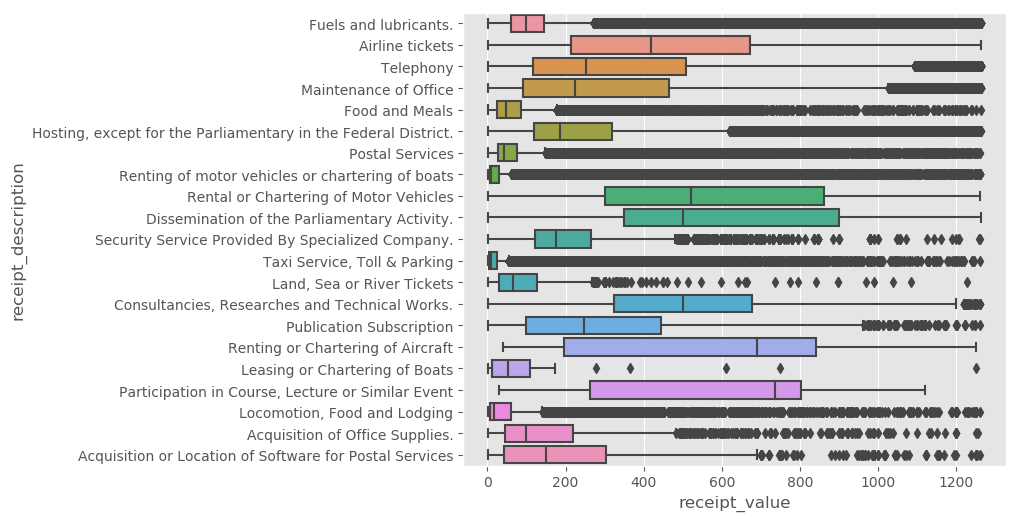

In [10]:
fig = plt.figure(figsize=(7,6), dpi=100)
sns.boxplot(data=reembolsos[~reembolsos['oulier_interquartil']], x='receipt_value', y='receipt_description')

In [14]:
reembolsos_regular = reembolsos[~reembolsos['oulier_interquartil']]
reembolsos_regular.shape

(2238768, 15)

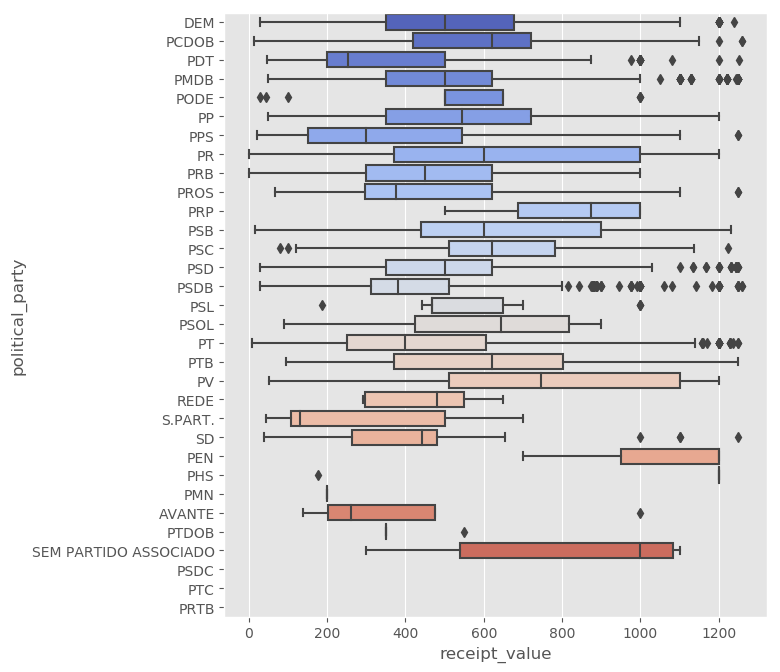

In [121]:
reembolso_sub_analise = reembolsos_regular[reembolsos_regular['receipt_description']=='Consultancies, Researches and Technical Works.']
# reembolso_sub_analise = reembolsos_regular[reembolsos_regular['receipt_description']=='Fuels and lubricants.']
# reembolso_sub_analise = reembolsos_regular[reembolsos_regular['receipt_description']=='Leasing or Chartering of Boats']
# reembolso_sub_analise = reembolsos_regular[reembolsos_regular['receipt_description']=='Dissemination of the Parliamentary Activity.']
# reembolso_sub_analise = reembolsos_regular[reembolsos_regular['receipt_description']=='Food and Meals']
# reembolso_sub_analise = reembolsos_regular

fig = plt.figure(figsize=(7,8), dpi=100)
sns.boxplot(x="receipt_value", y="political_party",data=reembolso_sub_analise, palette="coolwarm")

In [122]:
reembolso_sub_analise = reembolso_sub_analise[reembolso_sub_analise['receipt_year'] == 2015]

In [123]:
len(reembolso_sub_analise['receipt_social_security_number'].unique())

114

In [124]:
# reemb_dummie_party = pd.get_dummies(reembolso_sub_analise['political_party']).drop(['SEM PARTIDO ASSOCIADO','S.PART.'], axis=1)
# reemb_dummie_state = pd.get_dummies(reembolso_sub_analise['state_code']).drop('Vazio', axis=1)
reemb_dummie = reembolso_sub_analise.iloc[:,[2,3,4,5,6,9,10,11,12]]
reemb_dummie.head()

,deputy_id,political_party,state_code,deputy_name,receipt_social_security_number,receipt_value,receipt_year,receipt_month,receipt_day_of_month
1069228,2921,AVANTE,PE,Adalberto Cavalcanti,5205920000160.0,300.00,2015,12,1
1071955,3026,PSB,MT,Adilton Sachetti,9613772000173.0,600.00,2015,4,17
1072516,1773,PR,MG,Aelton Freitas,10688447000159.0,120.00,2015,7,3
1077331,2910,DEM,AC,Alan Rick,38049599000120.0,245.00,2015,9,21
1080765,1435,PTB,PR,Alex Canziani,15264646000153.0,594.00,2015,8,21


In [125]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(reemb_dummie['deputy_id'])
reemb_dummie['deputy_id_'] = le.transform(reemb_dummie['deputy_id'])

le.fit(reemb_dummie['political_party'])
reemb_dummie['political_party_'] = le.transform(reemb_dummie['political_party'])

le.fit(reemb_dummie['state_code'])
reemb_dummie['state_code_'] = le.transform(reemb_dummie['state_code'])

le.fit(reemb_dummie['receipt_social_security_number'])
reemb_dummie['receipt_social_security_number_'] = le.transform(reemb_dummie['receipt_social_security_number'])
reemb_dummie.head()

C:\Users\Marco\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Marco\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Marco\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html

,deputy_id,political_party,state_code,deputy_name,receipt_social_security_number,receipt_value,receipt_year,receipt_month,receipt_day_of_month,deputy_id_,political_party_,state_code_,receipt_social_security_number_
1069228,2921,AVANTE,PE,Adalberto Cavalcanti,5205920000160.0,300.00,2015,12,1,92,0,15,71
1071955,3026,PSB,MT,Adilton Sachetti,9613772000173.0,600.00,2015,4,17,119,11,12,112
1072516,1773,PR,MG,Aelton Freitas,10688447000159.0,120.00,2015,7,3,35,8,10,7
1077331,2910,DEM,AC,Alan Rick,38049599000120.0,245.00,2015,9,21,90,1,0,62
1080765,1435,PTB,PR,Alex Canziani,15264646000153.0,594.00,2015,8,21,19,18,17,29


In [126]:
reemb_dummie = reemb_dummie.iloc[:,[5, 6, 7, 8, 10, 11, 12]]
reemb_dummie.head()

,receipt_value,receipt_year,receipt_month,receipt_day_of_month,political_party_,state_code_,receipt_social_security_number_
1069228,300.00,2015,12,1,0,15,71
1071955,600.00,2015,4,17,11,12,112
1072516,120.00,2015,7,3,8,10,7
1077331,245.00,2015,9,21,1,0,62
1080765,594.00,2015,8,21,18,17,29


In [127]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(reemb_dummie)

scaled_data = scaler.transform(reemb_dummie)

In [128]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(scaled_data)

x_pca = pca.transform(scaled_data)



In [129]:
scaled_data.shape

(525, 7)

In [130]:
x_pca.shape

(525, 2)

Text(0,0.5,'Second Principal Component')

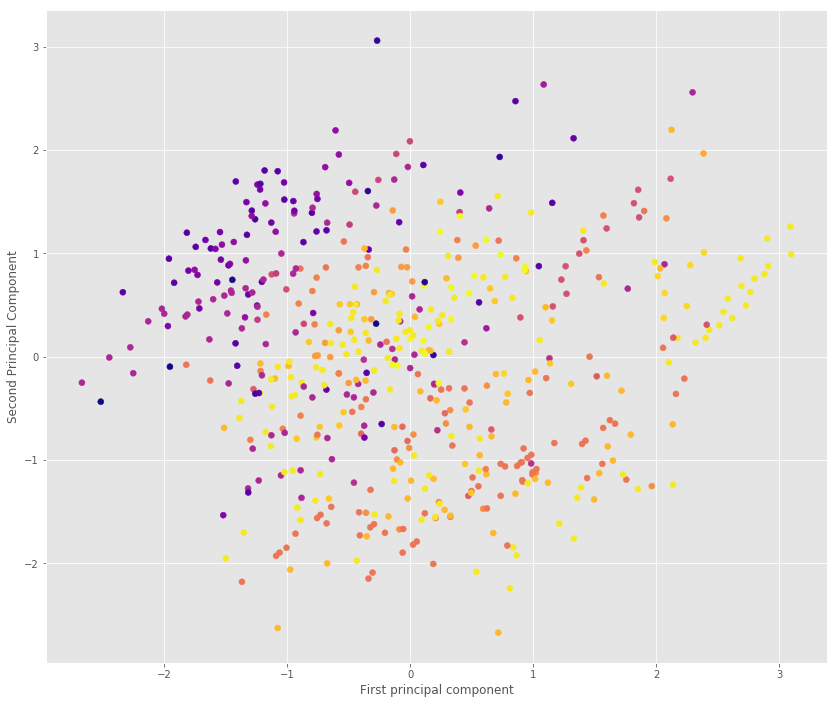

In [135]:
plt.figure(figsize=(14,12))
plt.scatter(x_pca[:,0],x_pca[:,1], c=reemb_dummie['state_code_'], cmap='plasma', )
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

In [132]:
df_comp = pd.DataFrame(pca.components_,columns=reemb_dummie.columns)

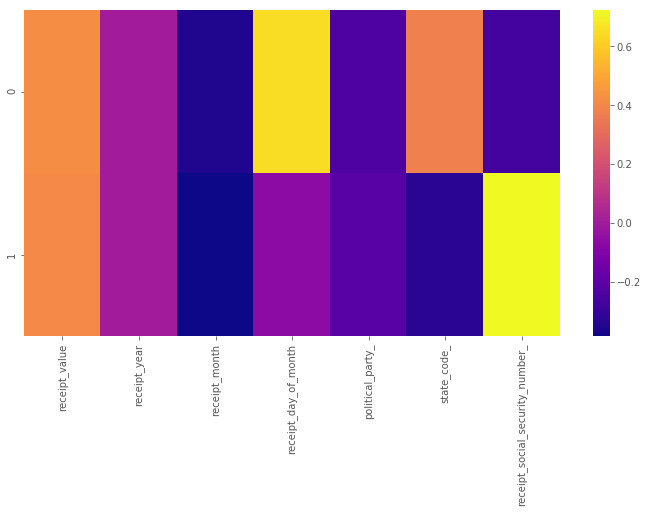

In [133]:
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,cmap='plasma',)